In [81]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import torch.nn.functional as F
import seaborn as sns
import numpy as np
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [4]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"  # Download the dataset
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

In [75]:
dataframe= pd.read_csv(DATA_FILENAME)   #Load csv file into dataframe
dataframe.head()   #Print first 5 records


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [78]:
input_cols = ["age","sex","bmi","children","smoker","region"]   #Features
categorical_cols = ["sex","smoker","region"]    #To convert non-numerical data into numerical 
output_cols = ["charges"]       #Target


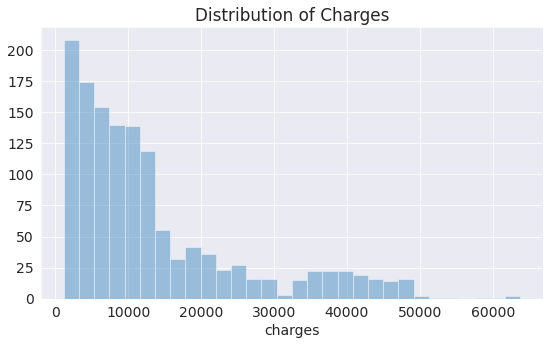

In [80]:
#Let's have a look at Distribution
sns.set_style("darkgrid")
plt.title("Distribution of Charges")
sns.distplot(dataframe['charges'], kde=False);


In [82]:
#To convert non-numerical data into numerical and separate input and output data

def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [85]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array[:3], targets_array[:3]    #Print first 3 records

(array([[19.  ,  0.  , 27.9 ,  0.  ,  1.  ,  3.  ],
        [18.  ,  1.  , 33.77,  1.  ,  0.  ,  2.  ],
        [28.  ,  1.  , 33.  ,  3.  ,  0.  ,  2.  ]]),
 array([[16884.924 ],
        [ 1725.5523],
        [ 4449.462 ]]))

In [87]:
#Convert numpy arrays to tensors with datatype as float32

inputs = torch.from_numpy(inputs_array).type(torch.float32)
targets = torch.from_numpy(targets_array).type(torch.float32)
inputs.dtype, targets.dtype,

(torch.float32, torch.float32)

In [91]:
#Create a Pytorch Database
dataset = TensorDataset(inputs, targets)

In [92]:
#Split Data into Test Set and Validation Set

from torch.utils.data import random_split
val_percent = 0.1          #Validation data is 10% of total dataset
num_rows=len(dataset)
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset,[train_size,val_size]) # Use the random_split function to split dataset into 2 parts of the desired length
len(dataset),len(train_ds),len(val_ds)

(1338, 1205, 133)

In [96]:
batch_size = 25  #pick a batch size for training data loader
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [99]:
#Print 1 batch
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[27.0000,  1.0000, 28.5000,  0.0000,  1.0000,  1.0000],
        [43.0000,  1.0000, 35.3100,  2.0000,  0.0000,  2.0000],
        [60.0000,  1.0000, 36.9550,  0.0000,  0.0000,  0.0000],
        [55.0000,  1.0000, 30.6850,  0.0000,  1.0000,  0.0000],
        [50.0000,  1.0000, 32.3000,  1.0000,  1.0000,  0.0000],
        [49.0000,  0.0000, 23.1800,  2.0000,  0.0000,  1.0000],
        [37.0000,  1.0000, 28.0250,  2.0000,  0.0000,  1.0000],
        [36.0000,  1.0000, 28.5950,  3.0000,  0.0000,  1.0000],
        [64.0000,  0.0000, 39.3300,  0.0000,  0.0000,  0.0000],
        [31.0000,  1.0000, 26.8850,  1.0000,  0.0000,  0.0000],
        [49.0000,  1.0000, 28.6900,  3.0000,  0.0000,  1.0000],
        [49.0000,  0.0000, 34.7700,  1.0000,  0.0000,  1.0000],
        [19.0000,  0.0000, 33.1100,  0.0000,  1.0000,  2.0000],
        [35.0000,  1.0000, 30.5000,  1.0000,  0.0000,  3.0000],
        [33.0000,  1.0000, 35.7500,  1.0000,  1.0000,  2.0000],
        [63.0000,  0.0000, 25.08

In [28]:
input_size = len(input_cols)
output_size = len(output_cols)
(input_size),(output_size)

(6, 1)

In [100]:
#Create a new Class

class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)  #instantiate the weights and biases
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch                 
        out = self(inputs)                      # Generate predictions
        loss = F.smooth_l1_loss(out, targets)   #We use the smooth_l1_loss method to calcultate loss 
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        out = self(inputs)                              # Generate predictions
        loss = F.smooth_l1_loss(out, targets)      #Calculate validation loss
        return {'val_loss': loss.detach()}         #Return a key pair for loss of the particualar validation batch
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}          #Return key pair for loss of all batches 
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 100th epoch
        if (epoch+1) % 100 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [101]:
#Initialize Module
model = InsuranceModel()  
list(model.parameters())

[Parameter containing:
 tensor([[ 0.4056, -0.2878,  0.2306,  0.2019, -0.1975, -0.0152]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.2107], requires_grad=True)]

In [103]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(x) for x in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)      #Use Stochastic Gradient Descent for training parameters
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)     #Get loss for the batch
            loss.backward()                       #Calculate Gradient
            optimizer.step()                      #Adjust the parameters
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)    #Get validaton loss for all batches using above trained parameters
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history                          #Return total validation loss for each epoch

In [106]:
#Print loss before training the module

model = InsuranceModel()
result = evaluate(model,val_loader) # Use the the evaluate function
print(result)

{'val_loss': 13456.5732421875}


# Start Training Module with diff Learning Rates and Epochs

In [107]:
epochs =1000
lr = 0.001
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [100], val_loss: 7210.3140
Epoch [200], val_loss: 7036.3354
Epoch [300], val_loss: 6976.3750
Epoch [400], val_loss: 6920.9204
Epoch [500], val_loss: 6868.8726
Epoch [600], val_loss: 6819.8003
Epoch [700], val_loss: 6773.8931
Epoch [800], val_loss: 6731.8267
Epoch [900], val_loss: 6703.0454
Epoch [1000], val_loss: 6678.5645


In [108]:
epochs =500
lr = 0.003
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [100], val_loss: 6628.2202
Epoch [200], val_loss: 6606.9688
Epoch [300], val_loss: 6600.7056
Epoch [400], val_loss: 6598.9292
Epoch [500], val_loss: 6597.1699


In [109]:
epochs =800
lr = 0.01
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [100], val_loss: 6591.3457
Epoch [200], val_loss: 6583.2583
Epoch [300], val_loss: 6574.9780
Epoch [400], val_loss: 6567.8813
Epoch [500], val_loss: 6560.1401
Epoch [600], val_loss: 6552.9790
Epoch [700], val_loss: 6545.3071
Epoch [800], val_loss: 6538.4961


In [110]:
epochs =1000
lr = 0.03
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [100], val_loss: 6519.6655
Epoch [200], val_loss: 6502.6948
Epoch [300], val_loss: 6488.3091
Epoch [400], val_loss: 6475.0054
Epoch [500], val_loss: 6463.3633
Epoch [600], val_loss: 6450.5269
Epoch [700], val_loss: 6439.4824
Epoch [800], val_loss: 6428.1099
Epoch [900], val_loss: 6418.5181
Epoch [1000], val_loss: 6407.8569


In [111]:
epochs =800
lr = 0.01
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [100], val_loss: 6405.3613
Epoch [200], val_loss: 6402.7344
Epoch [300], val_loss: 6399.4565
Epoch [400], val_loss: 6395.6011
Epoch [500], val_loss: 6393.5630
Epoch [600], val_loss: 6389.6978
Epoch [700], val_loss: 6386.8257
Epoch [800], val_loss: 6383.9888


Text(0.5, 1.0, 'Loss vs Epochs')

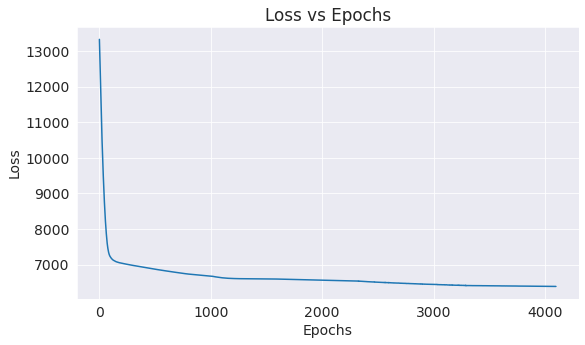

In [112]:
history= history1 +history2 +history3 +history4+history5  
loss=[x['val_loss'] for x in history]          #Combine all losses into single list
plt.plot(loss)                   
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss vs Epochs")

# Making predictions using the trained model



In [121]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)     #Unsqueeze so that single data can be evaluated 
    predictions = model(inputs)                
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [114]:
input, target = val_ds[38]
predict_single(input, target, model)

Input: tensor([51.0000,  0.0000, 39.5000,  1.0000,  0.0000,  3.0000])
Target: tensor([9880.0684])
Prediction: tensor([9474.5283])


In [125]:
input, target = val_ds[4]
predict_single(input, target, model)

Input: tensor([59.0000,  0.0000, 26.5050,  0.0000,  0.0000,  0.0000])
Target: tensor([12815.4453])
Prediction: tensor([12889.8984])


In [127]:
input, target = val_ds[15]
predict_single(input, target, model)

Input: tensor([41.0000,  1.0000, 23.9400,  1.0000,  0.0000,  0.0000])
Target: tensor([6858.4795])
Prediction: tensor([8663.3984])


In [128]:
input, target = val_ds[51]
predict_single(input, target, model)

Input: tensor([48.0000,  1.0000, 37.2900,  2.0000,  0.0000,  2.0000])
Target: tensor([8978.1855])
Prediction: tensor([9277.5000])
